In [6]:
import os
import time
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# set up
d_embed = 32
window_size = 5
Threshold_freq = 1

In [7]:
fp = open("file_names_all.txt", "w", encoding="utf-8")
cur_dir_path = './drive/MyDrive/WSJ'
dir_list = os.listdir(cur_dir_path)
list_all_file_paths = []
for a_dir in sorted(dir_list):
    path = os.path.join(cur_dir_path, a_dir)
    subdir_list = os.listdir(path)
    for a_file in sorted(subdir_list):
        if not(a_file[-1]=='S' and a_file[-2]=='O'):
            continue
        path2 = os.path.join(path, a_file)
        fp.write(path2+'\n')
        list_all_file_paths.append(path2)
fp.close()

In [10]:
# divide the whole corpus to 3 parts: training, validation, test
fp_tr = open("./file_names_train.txt", "w", encoding="utf-8")
fp_va = open("./file_names_validation.txt", "w", encoding="utf-8")
fp_te = open("./file_names_test.txt", "w", encoding="utf-8")

total_num_files = len(list_all_file_paths)
num_files_train = int(total_num_files * 0.8)
num_files_validation = int(total_num_files * 0.1)
num_files_test = total_num_files - (num_files_train + num_files_validation)

for i in range(num_files_train):
    fp_tr.write(list_all_file_paths[i] + '\n')
fp_tr.close()

for i in range(num_files_validation):
    fp_va.write(list_all_file_paths[num_files_train + i] + '\n')
fp_va.close()

for i in range(num_files_test):
    fp_te.write(list_all_file_paths[num_files_train + num_files_validation + i] + '\n')
fp_te.close()

In [13]:
# 입력: 한 tagged 파일의 경로
# 출력: 입력화일에 들어 있는 모든 문장의 줄을 읽어서 한 문장 내의 단어/품사 쌍을 모아 한 서브리스트에 넣고, 모든 문장들에 대한 서브리스트들을 한 리스트에 넣어서 이를 출력한다.
# 한 서브리스트는 한 문장마다 준비되며 각 원소는 문장 내의 단어/품사 쌍이다.
def read_a_file_and_form_sentences (file_path):
    fp = open(file_path, "r", encoding="utf-8")
    sentences_of_file = [] # this will have lists, where each list will have word/pos pairs of a sentence.

    while True: # this is for a sentence
        sentence = []
        while True:
            line = fp.readline()
            leng = len(line)
            if leng == 0:
                # EOF, Finish this file.
                return sentences_of_file
            elif leng == 1 or (line[0] == '=' and line[1] == '=' and line[2] == '='):
                continue
            else:
                # first line of a sentence has come. Store its elements.
                line = line[:-1]
                line_splited = line.split()
                for ele in line_splited:
                    if ele != '[' and ele != ']':
                        sentence.append(ele)
                break
        
        while True:
            line = fp.readline()
            leng = len(line)
            if leng == 0: # EOF
                break
            elif leng == 1 or (leng >= 4 and (line[0] == '=' and line[1] == '=' and line[2] == '=')):
                # the first garbage line after the last line of a sentence has come.
                break
            else:
                # next line of a sentence has come
                line = line[:-1]
                line_splited = line.split()

                for ele in line_splited:
                    if not (ele == '[' or ele == ']'):
                        sentence.append(ele)
            
        sentences_of_file.append(sentence)

        if leng == 0: # EOF
            break
    return sentences_of_file

In [14]:
# 한 문장을 한 줄에 가진다. 
# 문장은 단어/품사 들의 리스트이다. 
# 이 한 파일에 코퍼스 전체 모든 파일 내의 문장들을 가진다.
def build_word_pos_sentences(path_file_names, path_result_file):
    fp_n = open(path_file_names, "r", encoding="utf-8")
    fp_s = open(path_result_file, "w", encoding="utf-8")

    while True:
        filename = fp_n.readline()

        if len(filename) == 0:
            break # EOF
        
        filename = filename[:-1]
        sentences = read_a_file_and_form_sentences(filename)
        fp_s.write('<< ' + filename + ' >>  Num sentences: ' + str(len(sentences)) + '\n')

        # store word/pos in file 'all_word_pos_sentences_????.txt'
        for sentence in sentences:
            s_line = ''
            for w_p in sentence:
                s_line = s_line + ' ' + w_p
            fp_s.write(s_line+'\n')
    
    fp_n.close()
    fp_s.close()

In [15]:
build_word_pos_sentences("./file_names_all.txt", "./all_word_pos_sentences_all.txt")

build_word_pos_sentences("./file_names_train.txt", "./all_word_pos_sentences_train.txt")
build_word_pos_sentences("./file_names_validation.txt", "./all_word_pos_sentences_validation.txt")
build_word_pos_sentences("./file_names_test.txt", "./all_word_pos_sentences_test.txt")

In [31]:
# 사전을 만드는데 사용될 코퍼스에 등장하는 단어들과 그 출현 횟수를 가지는 사전(Vocab_temporary)을 생성
def build_vocabulary_temp(corpus_path):
    fp = open(corpus_path, "r", encoding="utf-8")
    for line in fp.readlines():
        sentence = line.split()
        if sentence[0] == '<<':
            continue
        for word_pos_pair in sentence:
            w_p = word_pos_pair.split('/')
            word = w_p[0]
            pos = w_p[1]
            if word in Vocab_temporary:
                Vocab_temporary[word] += 1
            else:
                Vocab_temporary[word] = 1
    fp.close()
    return

In [37]:
# Create Vocab of our system by taking words (in train part of the tagged corpus)
# of freq greater or equal to a given threshold

Vocab_temporary = {}
build_vocabulary_temp("./all_word_pos_sentences_all.txt")
sorted_Vocab = sorted(Vocab_temporary.items(), key = lambda kv: kv[1], reverse = True)
Total_n_words = len(sorted_Vocab)

Vocab = {}          # This will be our final vocab.
n_reversed = 2      # currently, [PAD] of index 0 , [UNK] of index 1
for i in range(Total_n_words):
    word = sorted_Vocab[i][0]
    freq = sorted_Vocab[i][1]

    if freq >= Threshold_freq:
        Vocab[word] = i + n_reversed    # give index to word
    else:
        # all the remaining will be ones of freq less than threshold freq.
        break

Vocab['[PAD]'] = 0  # index of pad word
Vocab['[UNK]'] = 1  # index of unknown word
Vocab_size = len(Vocab)     # include [PAD], [UNK]

# Create our dictionary for part of speech, dic_POS, from original paper of Penn-tree bank
dic_POS = {}
all_pos_list = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS',
                'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP','PRP$', 'RB',
                'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN',
                'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '#', '$', '.', ',',  
                ':', '(', ')', '\'\'', '\'', '``' ]

# give a unique index to each POS
for i in range(len(all_pos_list)):
    dic_POS[all_pos_list[i]] = i

In [41]:
# word_pos 파일로부터 index 파일을 생성
def build_index_sentences(path_word_pos_sentence_file, path_index_sentence_file):
    fp = open(path_word_pos_sentence_file, "r", encoding="utf-8")
    fp_w = open(path_index_sentence_file, "w", encoding="utf-8")

    for line in fp.readlines():
        sentence = line.split()
        if sentence[0] == '<<':
            continue
        
        line_widx = ''      # line for word indices
        line_pidx = ''      # line for pos indices

        for word_pos_pair in sentence:
            w_p = word_pos_pair.split('/')
            nseg = len(w_p)
            if nseg > 2:
                word = ''
                for i in range(nseg-1):
                    word = word + w_p[i] + '/'
                word = word[:-1]        # remove the last slash
            else:
                word = w_p[0]
            
            pos = w_p[-1]       # the last segment
            if not (word in Vocab):
                widx = 1        # give index of [UNK] since it is missing in Vocab.
            else:
                widx = Vocab[word]
            
            if not (pos in dic_POS):
                pos_list = pos.split('|')
                pos = pos_list[-1]
                if not (pos in dic_POS):
                    print("exception occurs at dic_POS look_up. w_p=", w_p, " pos=", pos)
                    time.sleep(100)
                else:
                    pidx = dic_POS[pos]
            else:
                pidx = dic_POS[pos]
            
            if len(line_widx) == 0:
                line_widx = line_widx + str(widx)
            else:
                line_widx = line_widx + '\t' + str(widx)
            
            if len(line_pidx) == 0:
                line_pidx = line_pidx + str(pidx)
            else:
                line_pidx = line_pidx + '\t' + str(pidx)

        fp_w.write(line_widx + '\n')
        fp_w.write(line_pidx + '\n')
        fp_w.write('\n')                # an empty line after each sentence
    fp_w.close()
    fp.close()

In [42]:
build_index_sentences("./all_word_pos_sentences_train.txt", "./all_index_sentences_train.txt")
build_index_sentences("./all_word_pos_sentences_validation.txt", "./all_index_sentences_validation.txt")
build_index_sentences("./all_word_pos_sentences_test.txt", "./all_index_sentences_test.txt")


In [43]:
# index 파일에서 train examples 파일 만들기.
def build_examples(path_index_file, path_examples_file, window_size):
    fp = open(path_index_file, "r", encoding="utf-8")
    fp_w = open(path_examples_file, "w", encoding="utf-8")

    fp_w.write(str(window_size) + " word indices and a pos label.\n")       # insert first line as comment
    
    num_pads = window_size // 2
    while True:
        # read two lines
        wline = fp.readline()
        if len(wline) == 0:
            break   #EOF
        pline = fp.readline()
        w_index = wline.split()
        p_index = pline.split()

        # pad (index 0) are placed before the sentence
        pad_added_word_index = []
        for i in range(num_pads):
            pad_added_word_index.append('0')
        
        for widx in w_index:
            pad_added_word_index.append(widx)
        
        # pads are added after sentence
        for i in range(num_pads):
            pad_added_word_index.append('0')
        
        leng_sentence = len(w_index)
        for i in range(leng_sentence):
            outline = ''
            for j in range(window_size):
                outline += pad_added_word_index[i+j]
                outline += '\t'
            outline += p_index[i] + '\n'
            fp_w.write(outline)
        
        line = fp.readline()
        if len(line) != 1:
            print("logic error. length 1 line expected in file all_index_sentences.txt")
            time.sleep(100)
    
    fp.close()
    fp_w.close()

In [44]:
build_examples("./all_index_sentences_train.txt", "./all_examples_train.txt", window_size)
build_examples("./all_index_sentences_validation.txt", "./all_examples_validation.txt", window_size)
build_examples("./all_index_sentences_test.txt", "./all_examples_test.txt", window_size)

In [69]:
# Read training examples for train and validation from example files.
# Lists x_train, y_train: X and d of training examples from training data.
# Lists x_validation, y_valdation: the same as the above.

def read_examples_from_file(path_examples_file):
    fp = open(path_examples_file, "r", encoding="utf-8")

    X = []
    Y = []
    for i, line in enumerate(fp.readlines()):
        if i == 0:
            continue    # ignore the first line wich is a comment
        line_split = line.split()
        intseq = [int(a) for a in line_split]
        an_inputX = intseq[0:window_size]
        X.append(an_inputX)     # X (an input word index seq)
        Y.append(intseq[-1])     # d (a label not a 1-hot vector)
    return X, Y

In [70]:
x_train, y_train = read_examples_from_file("./all_examples_train.txt")
x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation, y_validation = read_examples_from_file("./all_examples_validation.txt")
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

x_test, y_test = read_examples_from_file("./all_examples_test.txt")
x_test = np.array(x_test)
y_test = np.array(y_test)

In [71]:
y_train

array([13, 13, 39, ..., 28, 11, 38])

In [72]:
# Model design

embedding_layer = Embedding(Vocab_size, d_embed, embeddings_initializer='random_normal', input_length=window_size, trainable=True)

int_seq = keras.Input(shape=(window_size), dtype="int64")
emb_seq = embedding_layer(int_seq)
x = layers.Flatten()(emb_seq)
x = layers.Dense(640, activation="relu")(x)
x = layers.Dense(640, activation="relu")(x)
preds = layers.Dense(46, activation="softmax")(x)

model = keras.Model(int_seq, preds)

In [ ]:
# loss sparse_categorical_crossentropy: target is given as a label index than one-hot vector.
LEARNING_RATE = 0.3e-3
DECAY = 0.00005
EPOCHS = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay = DECAY)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])

hist = model.fit(x_train, y_train, batch_size=64, epochs=EPOCHS, validation_data=(x_validation, y_validation), shuffle=True)
# print(hist.history.keys())
# print('\nAccuracy: {:.4f}'.format(model.evaluate(X_validation, Y_validation)[1]))

Epoch 1/5
15850/15850 [==============================] - 165s 10ms/step - loss: 0.0583 - acc: 0.9805 - val_loss: 0.1452 - val_acc: 0.9562
Epoch 2/5
 3101/15850 [====>.........................] - ETA: 2:11 - loss: 0.0404 - acc: 0.9862

In [74]:
####### TEST ##########

pred = model.predict(x=x_test, verbose=1)   # batch 단위로 수행 (default = 32)
                                            # batch 별 결과를 모아서 전체 결과를 반환함
pred_label = tf.math.argmax(pred, axis=1)

leng_test = len(y_test)
equality = tf.math.equal(pred_label, y_test)    # boolean arrary
compare = np.ones(leng_test, dtype=np.int64)
for i in range(leng_test):
    if not equality[i]:
        compare[i] = 0
hit = tf.reduce_sum(compare)
acc = hit / leng_test
print("test accuarcy = ", acc)

4541/4541 [==============================] - 5s 1ms/step
test accuarcy =  tf.Tensor(0.9597654475629396, shape=(), dtype=float64)


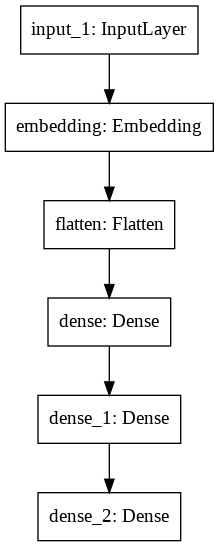

In [76]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()